In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# adjust the location of the dataset if folder structure changed!
df_raw = pd.read_parquet("../../01_data/train-00000-of-00001.parquet")
df_raw.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,SMA_5,...,Future_Category_1d,Future_Return_5d,Future_Up_5d,Future_Category_5d,Future_Return_10d,Future_Up_10d,Future_Category_10d,Future_Return_20d,Future_Up_20d,Future_Category_20d
0,2020-09-08 00:00:00-04:00,93.113965,93.462744,91.806050,92.174202,1225600,0.0,0.0,A,96.138635,...,3.0,0.054972,1,3.0,0.036578,1,3.0,0.070141,1,3.0
1,2020-09-09 00:00:00-04:00,93.104280,95.400403,92.871764,94.877235,954400,0.0,0.0,A,95.520526,...,2.0,0.020321,1,3.0,-0.010416,0,1.0,0.062670,1,3.0
2,2020-09-10 00:00:00-04:00,95.797603,96.979573,95.177554,95.497269,1933200,0.0,0.0,A,94.580765,...,2.0,0.010449,1,2.0,-0.022623,0,0.0,0.058616,1,3.0
3,2020-09-11 00:00:00-04:00,95.632924,96.514560,94.964430,95.526352,1368600,0.0,0.0,A,94.379250,...,2.0,0.007911,1,2.0,-0.009229,0,1.0,0.074550,1,3.0
4,2020-09-14 00:00:00-04:00,96.621112,97.105525,95.884801,96.320770,1207700,0.0,0.0,A,94.879166,...,2.0,-0.012975,0,1.0,0.000905,1,2.0,0.062363,1,3.0


Obtain the last day where stocks where traded.


In [2]:
df_raw['Date'].max()

'2025-06-27 00:00:00-04:00'

In [3]:
df_raw['Date'] = pd.to_datetime(df_raw['Date'])
print(df_raw['Date'].max())
print(df_raw['Date'].dtype)
print(type(df_raw['Date'].iloc[0]))

2025-06-27 00:00:00-04:00
object
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


/tmp/ipykernel_22666/54160603.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_raw['Date'] = pd.to_datetime(df_raw['Date'])


What were the Top 5 traded companies in the last 20 days in terms of dollar volume (volume \* close)?


In [4]:
last_date = df_raw['Date'].max()
twenty_days_before = last_date - pd.Timedelta(days=20)
print(twenty_days_before)

2025-06-07 00:00:00-04:00


In [5]:
df_raw['Dollar_volume'] = df_raw['Close'] * df_raw['Volume']
last_20_days = df_raw[df_raw['Date'] >= twenty_days_before]

In [6]:
selected_columns = ['Ticker', 'Date', 'Close', 'Volume', 'Dollar_volume']
last_20_days[selected_columns].head(10)
average_dollar_volume = last_20_days['Dollar_volume'].groupby(
    last_20_days['Ticker']).mean()
average_dollar_volume.sort_values(ascending=False).head(5)

Ticker
TSLA    3.780756e+10
NVDA    2.786071e+10
PLTR    1.124368e+10
AAPL    1.115792e+10
MSFT    1.003850e+10
Name: Dollar_volume, dtype: float64

However, all of these are technology companies. That does not seem to be really insightful.
From yfinance, obtain sectors for each ticker in the dataset.


In [7]:
import yfinance as yf

filepath = Path('ticker_sector_map.csv')
if filepath.exists():
    df = pd.read_csv('ticker_sector_map.csv')
    sector_map = dict(zip(df['ticker'], df['sector']))
else:
    tickers = df_raw['Ticker'].unique()
    sector_map = {}
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            sector = info.get('sector', 'Unknown')
            sector_map[ticker] = sector
        except Exception as e:
            sector_map[ticker] = 'Unknown'
            print(f"Error retrieving data for {ticker}: {e}")
    df = pd.DataFrame(list(sector_map.items()), columns=['ticker', 'sector'])
    df.to_csv('ticker_sector_map.csv', index=False)

In [8]:
missing_data = {
    'ANSS': 'Technology',
    'HES':  'Energy',
    'JNPR': 'Technology',
    'PARA': 'Communication Services',
    'WBA':  'Consumer Defensive'
}

# Update your dictionary
sector_map.update(missing_data)

# 1. Convert dictionary to DataFrame
sector_df = pd.DataFrame(list(sector_map.items()),
                         columns=['Ticker', 'Sector'])

# 2. Check unique values (The sectors you've found)
print(sector_df['Sector'].unique())

# 3. See the count of each sector
print(sector_df['Sector'].value_counts())

print(sector_df[sector_df['Sector'] == 'Unknown'])

['Healthcare' 'Utilities' 'Technology' 'Industrials' 'Consumer Cyclical'
 'Basic Materials' 'Real Estate' 'Financial Services'
 'Communication Services' 'Consumer Defensive' 'Energy']
Sector
Technology                82
Industrials               71
Financial Services        68
Healthcare                60
Consumer Cyclical         56
Consumer Defensive        38
Utilities                 31
Real Estate               31
Communication Services    23
Energy                    23
Basic Materials           20
Name: count, dtype: int64
Empty DataFrame
Columns: [Ticker, Sector]
Index: []


In [9]:
df_raw.shape

(620095, 74)

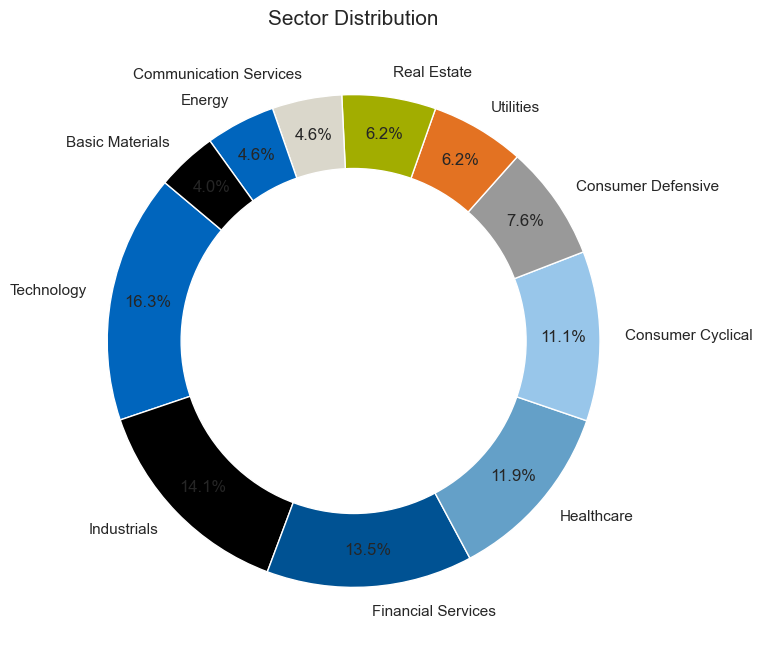

In [ ]:
import matplotlib.font_manager as fm

# 1. Prepare data
data = sector_df['Sector'].value_counts()

# 2. Set the Seaborn theme and palette
sns.set_theme(style="whitegrid")
font_path = '/mnt/c/Windows/Fonts/arial.ttf'
fm.fontManager.addfont(font_path)
sns.set_theme(font="Arial")
tum_hex_codes = [
    "#0065BD", "#005293",
    "#64A0C8", "#98C6EA", "#999999",
    "#E37222", "#A2AD00", "#DAD7CB"
]
colors = sns.color_palette(tum_hex_codes)[0:len(data)]

# 3. Plot
plt.figure(figsize=(10, 8))
plt.pie(
    data,
    labels=data.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    pctdistance=0.85  # Moves percentages closer to the edge
)

# 4. Add a circle at the center to make it a "Donut Chart" (optional but prettier)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Sector Distribution', fontsize=15)
plt.show()

In [12]:
df_raw['Sector'] = df_raw['Ticker'].map(sector_map)
df_raw.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,SMA_5,...,Future_Up_5d,Future_Category_5d,Future_Return_10d,Future_Up_10d,Future_Category_10d,Future_Return_20d,Future_Up_20d,Future_Category_20d,Dollar_volume,Sector
0,2020-09-08 00:00:00-04:00,93.113965,93.462744,91.806050,92.174202,1225600,0.0,0.0,A,96.138635,...,1,3.0,0.036578,1,3.0,0.070141,1,3.0,1.129687e+08,Healthcare
1,2020-09-09 00:00:00-04:00,93.104280,95.400403,92.871764,94.877235,954400,0.0,0.0,A,95.520526,...,1,3.0,-0.010416,0,1.0,0.062670,1,3.0,9.055083e+07,Healthcare
2,2020-09-10 00:00:00-04:00,95.797603,96.979573,95.177554,95.497269,1933200,0.0,0.0,A,94.580765,...,1,2.0,-0.022623,0,0.0,0.058616,1,3.0,1.846153e+08,Healthcare
3,2020-09-11 00:00:00-04:00,95.632924,96.514560,94.964430,95.526352,1368600,0.0,0.0,A,94.379250,...,1,2.0,-0.009229,0,1.0,0.074550,1,3.0,1.307374e+08,Healthcare
4,2020-09-14 00:00:00-04:00,96.621112,97.105525,95.884801,96.320770,1207700,0.0,0.0,A,94.879166,...,0,1.0,0.000905,1,2.0,0.062363,1,3.0,1.163266e+08,Healthcare


In [13]:
ticker_stats = df_raw.groupby(['Sector', 'Ticker'])[
    'Dollar_volume'].mean().reset_index()

ticker_stats = ticker_stats.sort_values(
    ['Sector', 'Dollar_volume'], ascending=[True, False])

top_3_per_sector = ticker_stats.groupby('Sector').head(3)

print(top_3_per_sector)

                     Sector Ticker  Dollar_volume
10          Basic Materials    LIN   6.494771e+08
8           Basic Materials    FCX   5.673749e+08
17          Basic Materials    SHW   4.179312e+08
30   Communication Services   META   6.642611e+09
27   Communication Services  GOOGL   4.077402e+09
26   Communication Services   GOOG   3.197840e+09
94        Consumer Cyclical   TSLA   2.486476e+10
45        Consumer Cyclical   AMZN   9.443931e+09
66        Consumer Cyclical     HD   1.145659e+09
106      Consumer Defensive   COST   1.222194e+09
136      Consumer Defensive    WMT   1.153363e+09
127      Consumer Defensive     PG   9.999802e+08
159                  Energy    XOM   1.627541e+09
141                  Energy    CVX   1.189547e+09
152                  Energy    OXY   7.079282e+08
195      Financial Services    JPM   1.737676e+09
224      Financial Services      V   1.719788e+09
184      Financial Services   COIN   1.609292e+09
281              Healthcare    UNH   1.756005e+09


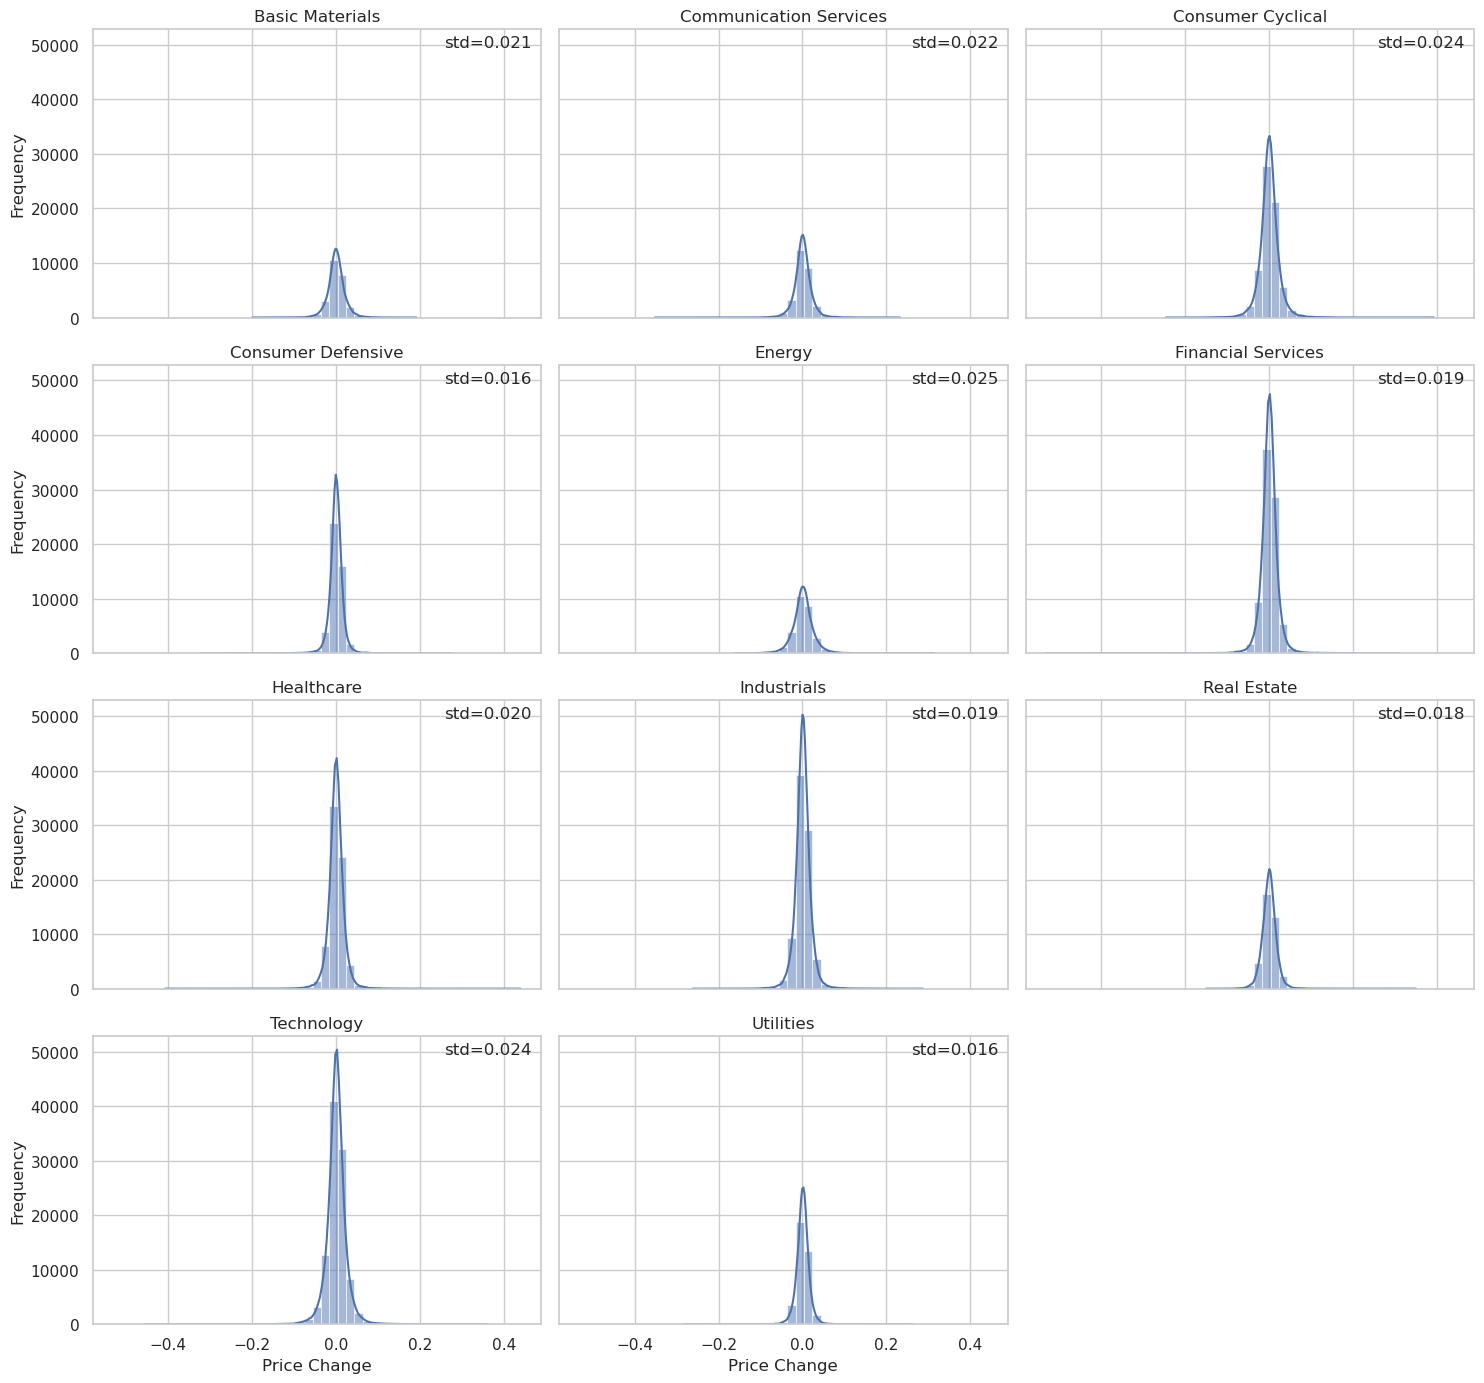

Distribution summary by sector:


,n,mean,std,min,median,max,skew,kurtosis
Sector,,,,,,,,
Technology,102025,0.0009,0.0241,-0.4568,0.0009,0.3594,0.2404,14.4284
Industrials,86629,0.0008,0.0188,-0.2616,0.0008,0.2868,0.1052,9.6320
Financial Services,84461,0.0008,0.0194,-0.5314,0.0009,0.3111,0.0186,17.1666
Healthcare,73096,0.0004,0.0196,-0.4066,0.0005,0.4397,0.0762,26.1167
Consumer Cyclical,68480,0.0008,0.0235,-0.2460,0.0006,0.3929,0.3421,9.7449
Consumer Defensive,46593,0.0002,0.0160,-0.3215,0.0004,0.2755,-0.7473,24.7414
Real Estate,38595,0.0005,0.0176,-0.1500,0.0006,0.3498,1.0316,18.3555
Utilities,38202,0.0006,0.0159,-0.2827,0.0008,0.2621,-0.1730,17.4218
Communication Services,28635,0.0006,0.0217,-0.3512,0.0006,0.2328,-0.3257,14.4750


In [19]:
# Histograms of Price Changes for every stock in a given sector with shared axes and a stats table
import numpy as np
# Prepare sector list and shared bins
sectors = sorted(df_raw['Sector'].dropna().unique())
n = len(sectors)
cols = 3
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(
    cols*5, rows*3.5), squeeze=False, sharex=True, sharey=True)
price_changes = df_raw['Price_Change'].dropna()
global_min, global_max = price_changes.min(), price_changes.max()
bins = np.linspace(global_min, global_max, 50)
for i, sector in enumerate(sectors):
    ax = axes[i // cols][i % cols]
    sector_data = df_raw[df_raw['Sector'] == sector]['Price_Change'].dropna()
    if sector_data.empty:
        ax.set_visible(False)
        continue
    sns.histplot(sector_data, bins=bins, kde=True, ax=ax, color='C0')
    ax.set_title(f'{sector}')
    ax.set_xlabel('Price Change')
    ax.set_ylabel('Frequency')
    std_dev = sector_data.std()
    ax.text(0.98, 0.98, f'std={std_dev:.3f}',
            transform=ax.transAxes, ha='right', va='top')
# hide any unused axes
for j in range(n, rows*cols):
    axes[j // cols][j % cols].set_visible(False)
plt.tight_layout()
plt.show()
# Summary statistics table for each sector
group = df_raw.groupby('Sector')['Price_Change']
stats_df = group.agg(['count', 'mean', 'std', 'min', 'median', 'max']).rename(
    columns={'count': 'n'})
stats_df['skew'] = group.skew()
# Use apply with Series.kurtosis() for compatibility across pandas versions
stats_df['kurtosis'] = group.apply(lambda x: x.kurtosis())
stats_df = stats_df.round(4).sort_values('n', ascending=False)
print('Distribution summary by sector:')
display(stats_df)

In [20]:
# Statistical tests comparing sectors' price change distributions
from scipy.stats import kruskal, mannwhitneyu
import pandas as pd
from itertools import combinations
import numpy as np

# Prepare groups
sectors = sorted(df_raw['Sector'].dropna().unique())
groups = [df_raw.loc[df_raw['Sector'] == s, 'Price_Change'].dropna()
          for s in sectors]
groups_nonempty = [g for g in groups if len(g) > 0]

if len(groups_nonempty) < 2:
    print('Not enough sectors with data to compare')
else:
    kw_stat, kw_p = kruskal(*groups_nonempty)
    print(f'Kruskal-Wallis H={kw_stat:.4f}, p={kw_p:.4e}')

    # Pairwise Mann-Whitney U with Bonferroni correction
    results = []
    for a, b in combinations(sectors, 2):
        xa = df_raw.loc[df_raw['Sector'] == a, 'Price_Change'].dropna()
        xb = df_raw.loc[df_raw['Sector'] == b, 'Price_Change'].dropna()
        if len(xa) < 2 or len(xb) < 2:
            results.append({'sector_a': a, 'sector_b': b, 'p': np.nan, 'stat': np.nan, 'n_a': len(
                xa), 'n_b': len(xb), 'median_a': np.nan, 'median_b': np.nan, 'cliffs_delta': np.nan})
            continue
        stat, p = mannwhitneyu(xa, xb, alternative='two-sided')
        # Cliff's delta (pairwise effect size)
        more = np.sum([np.sum(xb < xi) for xi in xa])
        less = np.sum([np.sum(xb > xi) for xi in xa])
        delta = (more - less) / (len(xa) * len(xb))
        results.append({'sector_a': a, 'sector_b': b, 'p': p, 'stat': stat, 'n_a': len(xa), 'n_b': len(
            xb), 'median_a': xa.median(), 'median_b': xb.median(), 'cliffs_delta': delta})

    res_df = pd.DataFrame(results)
    m = res_df['p'].notna().sum()
    alpha = 0.05
    # Bonferroni correction
    res_df['p_bonf'] = res_df['p'] * m
    res_df['p_bonf'] = res_df['p_bonf'].clip(upper=1.0)
    res_df['significant'] = res_df['p_bonf'] < alpha
    res_df = res_df.sort_values('p').reset_index(drop=True)
    print('Pairwise Mann-Whitney U tests (Bonferroni-corrected):')
    display(res_df[['sector_a', 'sector_b', 'n_a', 'n_b', 'median_a',
            'median_b', 'stat', 'p', 'p_bonf', 'significant', 'cliffs_delta']])

Kruskal-Wallis H=89.1631, p=7.8473e-15
Pairwise Mann-Whitney U tests (Bonferroni-corrected):


,sector_a,sector_b,n_a,n_b,median_a,median_b,stat,p,p_bonf,significant,cliffs_delta
0,Consumer Defensive,Financial Services,46593,84461,0.000436,0.000910,1.930280e+09,1.200666e-08,6.603662e-07,True,-0.018990
1,Consumer Defensive,Technology,46593,102025,0.000436,0.000920,2.333173e+09,1.277148e-08,7.024315e-07,True,-0.018366
2,Healthcare,Technology,73096,102025,0.000456,0.000920,3.671897e+09,4.885962e-08,2.687279e-06,True,-0.015263
3,Consumer Defensive,Energy,46593,28479,0.000436,0.001062,6.479799e+08,7.737591e-08,4.255675e-06,True,-0.023334
4,Financial Services,Healthcare,84461,73096,0.000910,0.000456,3.134850e+09,9.933385e-08,5.463362e-06,True,0.015540
5,Consumer Defensive,Industrials,46593,86629,0.000436,0.000846,1.983836e+09,2.953778e-07,1.624578e-05,True,-0.017004
6,Energy,Healthcare,28479,73096,0.001062,0.000456,1.061859e+09,5.592698e-07,3.075984e-05,True,0.020184
7,Healthcare,Industrials,73096,86629,0.000456,0.000846,3.121764e+09,1.358040e-06,7.469220e-05,True,-0.014009
8,Energy,Real Estate,28479,38595,0.001062,0.000591,5.605159e+08,1.011718e-05,5.564448e-04,True,0.019911
9,Real Estate,Technology,38595,102025,0.000591,0.000920,1.939652e+09,1.746348e-05,9.604914e-04,True,-0.014819


In [31]:
# Pooled baseline prediction pipeline with robust feature engineering
import numpy as np
import pandas as pd
import warnings
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

# Working copy of raw data
df_all = df_raw.copy()
# Ensure sorting by ticker and date
if 'Ticker' in df_all.columns and 'Date' in df_all.columns:
    df_all = df_all.sort_values(['Ticker', 'Date']).reset_index(drop=True)

# Basic returns and next-day label
df_all['Return'] = df_all.groupby('Ticker')['Close'].pct_change()
# next-day return (label target)
df_all['Return_next'] = df_all.groupby(
    'Ticker')['Close'].pct_change().shift(-1)
# binary label: up next day
df_all['y'] = (df_all['Return_next'] > 0).astype(int)

# Feature windows
wins = [1, 5, 10]
for w in wins:
    df_all[f'ret_lag_{w}'] = df_all.groupby('Ticker')['Return'].shift(w)
    # rolling stats with min_periods=1 to avoid dropping short histories
    df_all[f'ret_roll_mean_{w}'] = (
        df_all.groupby('Ticker')['Return']
              .rolling(window=w, min_periods=1)
              .mean()
              .reset_index(level=0, drop=True)
    )
    # use ddof=0 so std of a single value is 0 (not NaN)
    df_all[f'ret_roll_std_{w}'] = (
        df_all.groupby('Ticker')['Return']
              .rolling(window=w, min_periods=1)
              .std(ddof=0)
              .reset_index(level=0, drop=True)
    )
    df_all[f'ret_roll_std_{w}'] = df_all[f'ret_roll_std_{w}'].fillna(0)

# volume features
if 'Volume' in df_all.columns:
    df_all['vol_lag_1'] = df_all.groupby('Ticker')['Volume'].shift(1)
    df_all['vol_change'] = df_all['Volume'] / \
        (df_all['vol_lag_1'].fillna(0) + 1)

# Fill missing sector and dummies
if 'Sector' in df_all.columns:
    df_all['Sector'] = df_all['Sector'].fillna('Unknown')
    df_all = pd.get_dummies(df_all, columns=['Sector'], drop_first=True)

# Select feature columns
feature_prefixes = ['ret_lag_', 'ret_roll_mean_', 'ret_roll_std_', 'vol_']
feature_cols = [c for c in df_all.columns if any(
    c.startswith(p) for p in feature_prefixes)]
sector_cols = [c for c in df_all.columns if c.startswith('Sector_')]
use_cols = feature_cols + sector_cols + ['y', 'Date', 'Ticker', 'Return_next']
use_cols = [c for c in use_cols if c in df_all.columns]

df_model = df_all[use_cols].copy()
# Keep only rows where label exists (we must have a y to train/test on)
df_model = df_model[df_model['y'].notna()].copy()

if df_model.empty:
    print('No data available after feature engineering (df_model is empty). Check input data and feature windows.')
else:
    # Impute per-ticker using forward/backfill so short histories keep available features
    df_model = df_model.groupby('Ticker').apply(lambda g: g.fillna(
        method='ffill').fillna(method='bfill')).reset_index(drop=True)
    # final drop of rows that still miss essential features (only require features that actually have values)
    essential_feats = [
        c for c in feature_cols if c in df_model.columns and df_model[c].notna().sum() > 0]
    if len(essential_feats) == 0:
        print('No usable feature columns found after imputation. Check feature generation.')
        df_model = df_model.dropna(subset=['y'], how='any')
    else:
        df_model = df_model.dropna(subset=['y'] + essential_feats, how='any')

    if df_model.empty:
        print('No data left after per-ticker imputation and essential feature filtering.')
    else:
        # time-aware split: 80% train, 20% test by time (global)
        df_model['Date'] = pd.to_datetime(df_model['Date'], utc=True)
        df_model = df_model.sort_values('Date').reset_index(drop=True)
        split_idx = int(len(df_model) * 0.8)
        if split_idx < 1 or split_idx >= len(df_model):
            print(
                'Not enough rows to perform train/test split after feature engineering:', len(df_model))
        else:
            train = df_model.iloc[:split_idx]
            test = df_model.iloc[split_idx:]
            X_train = train.drop(
                ['y', 'Date', 'Ticker', 'Return_next'], axis=1, errors='ignore')
            y_train = train['y']
            X_test = test.drop(
                ['y', 'Date', 'Ticker', 'Return_next'], axis=1, errors='ignore')
            y_test = test['y']

            print('df_model.shape =', df_model.shape)
            print('X_train.shape =', X_train.shape,
                  'X_test.shape =', X_test.shape)

            if X_train.shape[0] == 0 or X_train.shape[1] == 0:
                print('Insufficient training data/features after processing.')
            else:
                try:
                    import lightgbm as lgb
                    model = lgb.LGBMClassifier(
                        n_estimators=200, random_state=42)
                except Exception:
                    model = RandomForestClassifier(
                        n_estimators=200, random_state=42, n_jobs=-1)

                try:
                    model.fit(X_train, y_train)
                except Exception as e:
                    print('Model training error:', e)
                    print('X_train.shape:', X_train.shape,
                          'y_train.shape:', y_train.shape)
                    raise

                # Predictions and metrics
                if hasattr(model, 'predict_proba'):
                    probs = model.predict_proba(X_test)[:, 1]
                else:
                    probs = model.predict(X_test)
                preds = (probs >= 0.5).astype(int)

                overall_auc = roc_auc_score(y_test, probs) if len(
                    np.unique(y_test)) > 1 else np.nan
                overall_acc = accuracy_score(y_test, preds)
                print(
                    f'Overall test AUC: {overall_auc:.4f}  Accuracy: {overall_acc:.4f}')

                # Per-sector evaluation if sector dummies exist
                if sector_cols:
                    def pick_sector(row):
                        for c in sector_cols:
                            if row.get(c, 0) == 1:
                                return c.replace('Sector_', '')
                        return 'Unknown'
                    sectors_test = X_test.apply(pick_sector, axis=1)
                    eval_df = pd.DataFrame(
                        {'sector': sectors_test, 'y': y_test.values, 'prob': probs})

                    def safe_auc(a, b):
                        try:
                            return roc_auc_score(a, b) if len(np.unique(a)) > 1 else np.nan
                        except Exception:
                            return np.nan
                    per_sector = eval_df.groupby('sector').apply(lambda d: pd.Series({'n': len(
                        d), 'auc': safe_auc(d['y'], d['prob']), 'acc': (d['prob'] >= 0.5).mean()}))
                    display(per_sector.sort_values('n', ascending=False))

                # Simple daily long-only top-10% backtest
                test_full = test.copy()
                test_full['pred_prob'] = probs
                bt_returns = []
                for date, grp in test_full.groupby('Date'):
                    if grp.empty:
                        continue
                    cutoff = grp['pred_prob'].quantile(0.9)
                    longs = grp[grp['pred_prob'] >= cutoff]
                    rets = longs['Return_next'].dropna(
                    ).values if 'Return_next' in longs.columns else np.array([])
                    bt_returns.append(np.nanmean(rets) if len(rets) > 0 else 0)
                if len(bt_returns) == 0:
                    print(
                        'Backtest produced no daily returns (maybe dates or labels are missing).')
                else:
                    cum = np.nancumprod([1 + r for r in bt_returns]) - 1
                    print(f'Simple backtest cumulative return: {cum[-1]:.4f}')

df_model.shape = (620095, 25)
X_train.shape = (496076, 21) X_test.shape = (124019, 21)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 256617, number of negative: 239459
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2570
[LightGBM] [Info] Number of data points in the train set: 496076, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517294 -> initscore=0.069202
[LightGBM] [Info] Start training from score 0.069202
Overall test AUC: 0.5090  Accuracy: 0.5200


,n,auc,acc
sector,,,
Technology,20212.0,0.506121,0.773006
Industrials,17506.0,0.502167,0.798583
Financial Services,16772.0,0.507826,0.817195
Healthcare,14798.0,0.509167,0.769293
Consumer Cyclical,13802.0,0.505375,0.784379
Consumer Defensive,9371.0,0.521778,0.842600
Real Estate,7642.0,0.537733,0.833551
Utilities,7641.0,0.504012,0.854993
Communication Services,5673.0,0.511415,0.686233


Simple backtest cumulative return: 0.2241
